# Flight Ticket Price Prediction

- Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable.

- Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

In [1]:
#importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
#from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor

from sklearn.preprocessing import LabelEncoder

from sklearn.externals import joblib

C:\Users\CHIT CHAT\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Data Loading

In [2]:
df = pd.read_excel('data/Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.shape

(10683, 11)

In [4]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


The maximum ticket price is Rs.79512 and minimum is Rs.1759

In [5]:
df.describe(include = ['O']) # 'o' stands for objects

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,10683,10683,10683,10683,10682,10683,10683,10683,10682,10683
unique,12,44,5,6,128,222,1343,368,5,10
top,Jet Airways,18/05/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info
freq,3849,504,4537,4537,2376,233,423,550,5625,8345


In [6]:
print("Source of the journey::",df['Source'].unique())
print("Destination of the journey::",df['Destination'].unique())


Source of the journey:: ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
Destination of the journey:: ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']


All the flight are from 5 different cities to all other 6 different cities except the same city.



In [7]:
df.isnull().sum() #checking for null value

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


There is only single entry is missing in Route and Total_stops.

#### Sorting the entire dataset on date of journey.

In [8]:
df.sort_values('Date_of_Journey', inplace = True)

#### Converting the Date_of_journey into date, month and year.

In [9]:
df['year'] = pd.DatetimeIndex(df['Date_of_Journey']).year
df['month'] = pd.DatetimeIndex(df['Date_of_Journey']).month
df['Day'] = pd.DatetimeIndex(df['Date_of_Journey']).day

In [10]:
df['Additional_Info'].unique()

array(['No info', '1 Long layover', 'Business class', 'Red-eye flight',
       'Change airports', '2 Long layover', 'No Info', '1 Short layover',
       'In-flight meal not included', 'No check-in baggage included'],
      dtype=object)

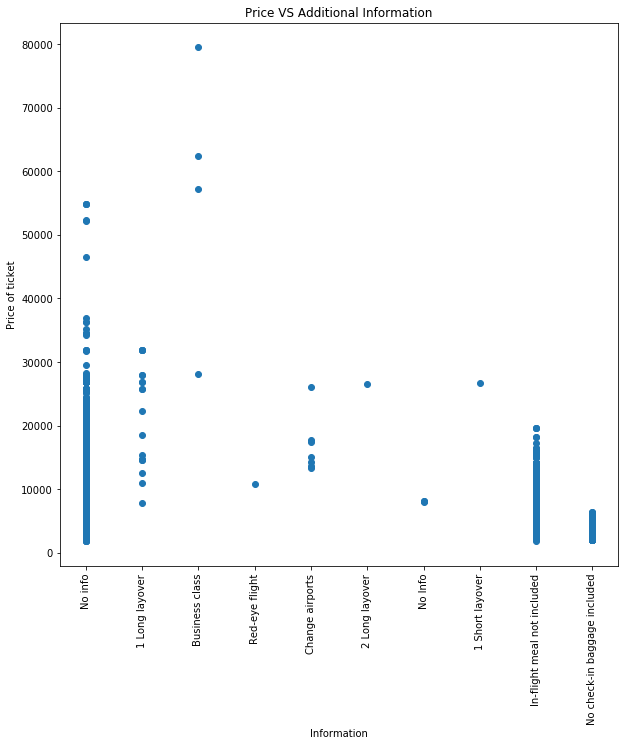

In [11]:
#Plotting Price vs Additional Information
plt.figure(figsize = (10, 10))
plt.title('Price VS Additional Information')
plt.scatter(df['Additional_Info'], df['Price'])
plt.xticks(rotation = 90)
plt.xlabel('Information')
plt.ylabel('Price of ticket');

From above scatter plot it is clear that the ticket prices for Business class is higher which is quite obivious.

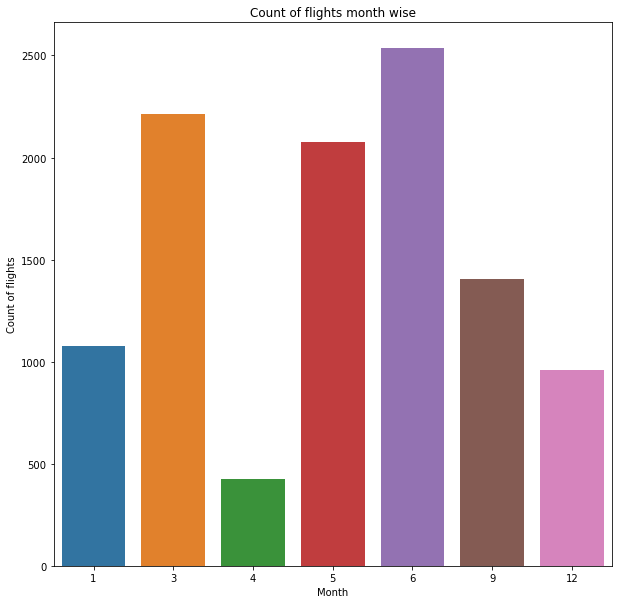

In [12]:
#Month wise flight count
plt.figure(figsize = (10 , 10))
plt.title('Count of flights month wise')
sns.countplot(x = 'month', data = df)
plt.xlabel('Month')
plt.ylabel('Count of flights');

There are around 2500 flights scheduled in the month of may so at this time can be the peak month for the airlines as compared to april which seems like slack season for airlines.

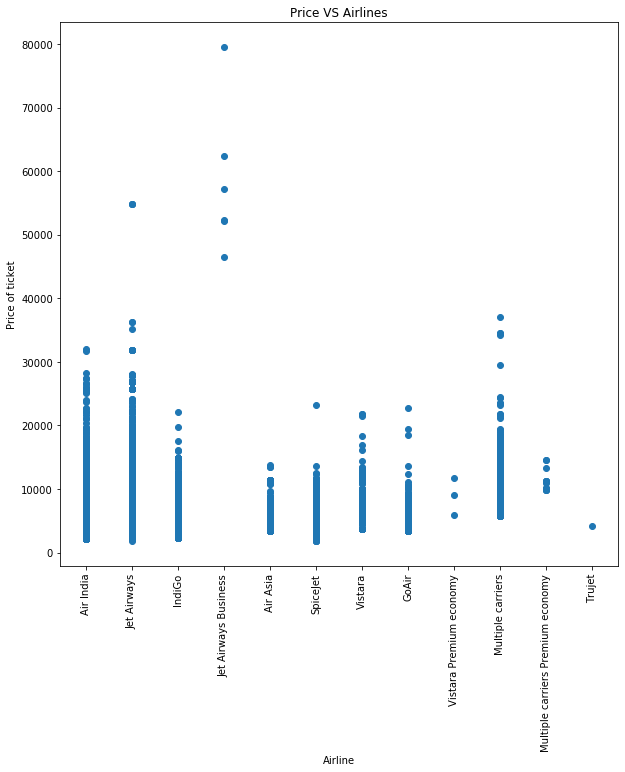

In [13]:
#plotting Price vs Airlines
plt.figure(figsize = (10, 10))
plt.title('Price VS Airlines')
plt.scatter(df['Airline'], df['Price'])
plt.xticks(rotation = 90)
plt.xlabel('Airline')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90);

The ticket rate for Jet Airways Business airline is high.

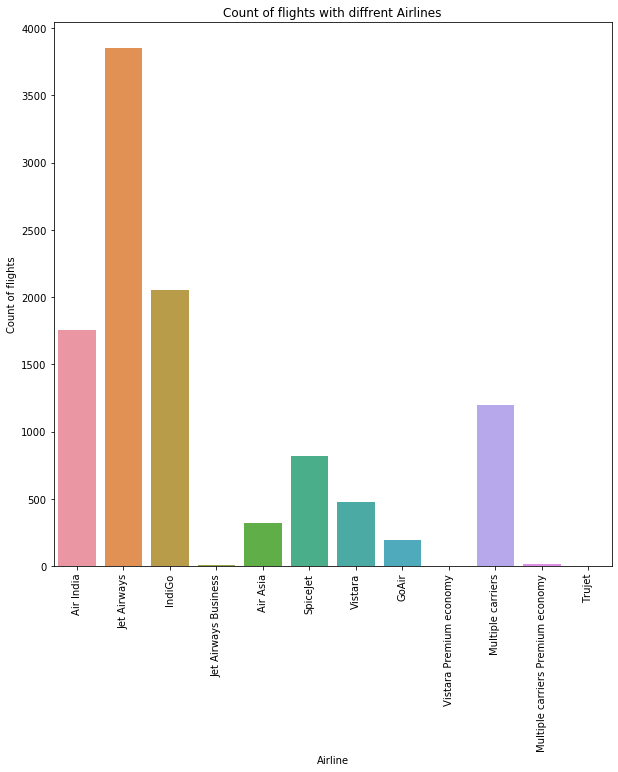

In [14]:
plt.figure(figsize = (10, 10))
plt.title('Count of flights with diffrent Airlines')
sns.countplot(x = 'Airline', data = df)
plt.xlabel('Airline')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90);

- There are more number of flights of Jet Airways.
- Jet Airways Business, Vistara Premium economy, Trujet have actually almost negligible flights.

#### Converting sparse classes of Airline into one category

In [15]:
df['Airline'].replace(['Trujet', 'Vistara Premium economy'], 'Another', inplace = True)

#### Converting the Total_Stops into numbers and dropping the rows with NaN.

In [16]:
df[df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,Day
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480,2019,6,5


In [17]:
df.dropna(axis = 0, inplace = True)

In [18]:
def convert_into_stops(X):
    if X == '4 stops':
        return 4
    elif X == '3 stops':
        return 3
    elif X == '2 stops':
        return 2
    elif X == '1 stop':
        return 1
    elif X == 'non stop':
        return 0

In [19]:
df['Total_Stops'] = df['Total_Stops'].map(convert_into_stops)

In [20]:
df['Total_Stops']

9848     2.0
6024     1.0
2405     1.0
10383    1.0
8308     NaN
        ... 
2875     1.0
2874     1.0
2873     1.0
6479     NaN
7297     2.0
Name: Total_Stops, Length: 10682, dtype: float64

In [21]:
df.fillna(0, inplace  = True)
df['Total_Stops'] = df['Total_Stops'].apply(lambda x : int(x))

#### Converting the flight Dep_Time into proper time i.e. mid_night, morning, afternoon and evening.

In [22]:
def flight_dep_time(X):
    '''
    This function takes the flight Departure time 
    and convert into appropriate format.
    '''
    if int(X[:2]) >= 0 and int(X[:2]) < 6:
        return 'mid_night'
    elif int(X[:2]) >= 6 and int(X[:2]) < 12:
        return 'morning'
    elif int(X[:2]) >= 12 and int(X[:2]) < 18:
        return 'afternoon'
    elif int(X[:2]) >= 18 and int(X[:2]) < 24:
        return 'evening'

Text(0, 0.5, 'Count of flights')

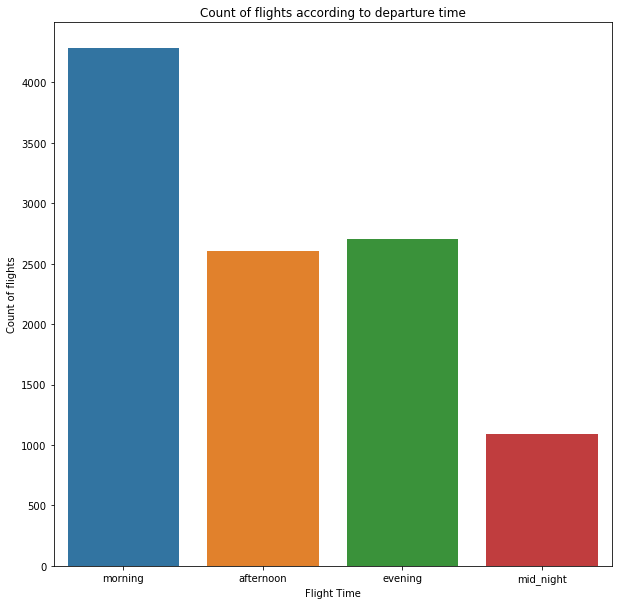

In [23]:
df['flight_time'] = df['Dep_Time'].apply(flight_dep_time)

plt.figure(figsize = (10, 10))
plt.title('Count of flights according to departure time')
sns.countplot(x = 'flight_time', data = df)
plt.xlabel('Flight Time')
plt.ylabel('Count of flights')

- There are more number of flights in the morning time as compared to other time.

#### Converting the flight duration into seconds

In [24]:
def convert_into_seconds(X):
    '''
    This function takes the total time of flight from
    one city to another and converts it into the seconds.
    '''
    a = [int(s) for s in re.findall(r'-?\d+\.?\d*', X)]
    if len(a) == 2:
        hr = a[0] * 3600
        min = a[1] * 60
    else:
        hr = a[0] * 3600
        min = 0   
    total = hr + min
    return total

df['Duration(sec)'] = df['Duration'].map(convert_into_seconds)

Text(0, 0.5, 'Price of ticket')

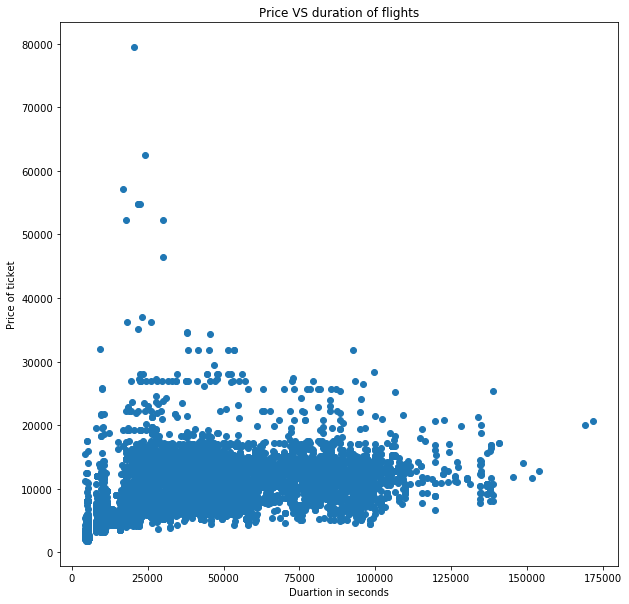

In [25]:
plt.figure(figsize = (10, 10))
plt.title('Price VS duration of flights')
plt.scatter(df['Duration(sec)'], df['Price'])
plt.xlabel('Duartion in seconds')
plt.ylabel('Price of ticket')

In [26]:
df.corr()  #Computing pairwise correlation of columns, excluding NA/null values.

,Total_Stops,Price,year,month,Day,Duration(sec)
Total_Stops,1.000000,0.603897,NaN,0.065495,-0.024136,0.738204
Price,0.603897,1.000000,NaN,0.010705,-0.165448,0.506604
year,NaN,NaN,NaN,NaN,NaN,NaN
month,0.065495,0.010705,NaN,1.000000,-0.264896,0.055147
Day,-0.024136,-0.165448,NaN,-0.264896,1.000000,-0.038422
Duration(sec),0.738204,0.506604,NaN,0.055147,-0.038422,1.000000


It is important to notice that the correlation for 'year' is shown NaN. This is because that feature is not vary at all.

#### Dropping the duplicate rows

In [27]:
df.shape

(10682, 16)

In [28]:
df = df.drop_duplicates()
df.shape

(10462, 16)

It looks like there were around 220 duplicate rows.

#### Handling the Typos

In [29]:
df['Additional_Info'].unique()

array(['No info', '1 Long layover', 'Business class', 'Red-eye flight',
       'Change airports', '2 Long layover', 'No Info', '1 Short layover',
       'In-flight meal not included', 'No check-in baggage included'],
      dtype=object)

'No info' is same as 'No Info'. So replacing them with single common label.

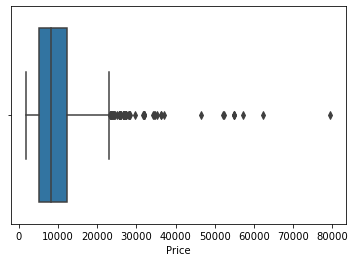

In [30]:
df['Additional_Info'].replace('No Info', 'No info', inplace = True)
sns.boxplot(df['Price'])

As we can see that there are some points which are seeems like outliers but we cannot remove them because these can be flight ticket price also.

#### Before we move to the next module, let's save the new dataframe that we have cleaned.

In [31]:
df.to_csv('data/cleaned_data.csv', index = None)

#### Encoding the dummy variables (for catagorical features)

In [32]:
df = pd.get_dummies(df, columns = ['Airline', 'Source', 'Destination', 'Additional_Info', 'flight_time'])

In [33]:
pd.set_option('display.max_columns', 50)
df.head()

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,year,month,Day,Duration(sec),Airline_Air Asia,Airline_Air India,Airline_Another,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight,flight_time_afternoon,flight_time_evening,flight_time_mid_night,flight_time_morning
9848,01/03/2019,BLR → BOM → AMD → DEL,08:50,23:55 02 Mar,39h 5m,2,17135,2019,1,3,140700,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
6024,01/03/2019,BLR → MAA → DEL,11:50,08:55 02 Mar,21h 5m,1,14594,2019,1,3,75900,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2405,01/03/2019,BLR → BOM → DEL,14:05,07:40 02 Mar,17h 35m,1,22270,2019,1,3,63300,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
10383,01/03/2019,BLR → BOM → DEL,07:00,05:05 02 Mar,22h 5m,1,26890,2019,1,3,79500,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
8308,01/03/2019,BLR → DEL,18:25,21:20,2h 55m,0,12649,2019,1,3,10500,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


#### Removing the unused features.

In [34]:
df.drop(['Date_of_Journey', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration'], axis = 1, inplace = True)

#### Saving the final dataframe to directory.

In [35]:
df.to_csv('data/final_data.csv', index = None)

#### Preparing the data for ML models.

In [36]:
y = df['Price']
X = df.drop('Price', axis = 1)

#### Data Standardization

In [37]:
s = StandardScaler()
X = s.fit_transform(X)

In [38]:
print(X.mean())
X.std()

1.3668201641342015e-18


0.9874208829065749

In [39]:
# Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [40]:
print("The size of training input is", X_train.shape)
print("The size of training output is", y_train.shape)
print(50 *'*')
print("The size of testing input is", X_test.shape)
print("The size of testing output is", y_test.shape)

The size of training input is (8369, 40)
The size of training output is (8369,)
**************************************************
The size of testing input is (2093, 40)
The size of testing output is (2093,)


### Working with Machine Learning Models

#### 1. Baseline Model

- In baseline model we predict the flight ticket price as average of all the prices.
- We will use this baseline model to perform hypothesis testing for other complex models.


In [41]:
y_train_pred = np.ones(X_train.shape[0]) * y_train.mean()
y_test_pred = np.ones(X_test.shape[0]) * y_train.mean()

In [47]:
print("Train Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", rmse_score)
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Standard Deviation ",np.std(sqrt(mse(y_train.values, y_train_pred))))

Train Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  4669.4866062245
R-squared:  0.0
Standard Deviation  0.0


In [46]:
print("Test Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))
print("Standard Deviation ",np.std(sqrt(mse(y_test, y_test_pred))))

Test Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  4440.965817495869
R-squared:  -0.0005214763052854288
Standard Deviation  0.0


#### 2. KNN Regressor

In [48]:
k_range = list(range(1, 30))
params = dict(n_neighbors = k_range)
knn_regressor = GridSearchCV(KNeighborsRegressor(), params, cv = 10, scoring = 'neg_mean_squared_error')
knn_regressor.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [49]:
print(knn_regressor.best_estimator_)
knn_regressor.best_params_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')


{'n_neighbors': 4}

In [50]:
y_train_pred =knn_regressor.predict(X_train) ##Predict train result
y_test_pred =knn_regressor.predict(X_test) ##Predict test result

In [86]:
print("Train Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Standard Deviation ",np.std(sqrt(mse(y_train.values, y_train_pred))))

pd.DataFrame({'Price':y_train,'Price Predicted':y_train_pred}).head(10)

Train Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  418.5459086493368
R-squared:  0.9919657020402473
Standard Deviation  0.0


,Price,Price Predicted
5416,9646,9646.0
2663,4174,4174.0
9074,8098,8098.0
2925,3210,3210.0
2694,4226,4226.0
947,13941,13941.0
10152,4804,4804.0
3594,4804,4804.0
9509,15554,15554.0
6529,15190,15190.0


In [87]:
print("Test Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))
print("Standard Deviation ",np.std(sqrt(mse(y_test, y_test_pred))))

pd.DataFrame({'Price':y_test,'Price Predicted':y_test_pred}).head(10)

Test Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  2751.95319137805
R-squared:  0.615803291624377
Standard Deviation  0.0


,Price,Price Predicted
7093,7531,11396.5
8949,13377,7198.0
6753,4508,3873.0
1538,11234,12305.0
7571,4990,5780.0
2384,10413,8576.0
7065,6015,5000.0
7833,8016,18308.0
1046,14924,14714.0
3937,8016,8016.0


#### 3. Ridge Regression

In [53]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor =GridSearchCV(Ridge(), params ,cv =5,scoring = 'neg_mean_absolute_error', n_jobs =-1)
ridge_regressor.fit(X_train ,y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [54]:
print(ridge_regressor.best_estimator_)
ridge_regressor.best_params_

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


{'alpha': 100}

In [55]:
y_train_pred =ridge_regressor.predict(X_train) ##Predict train result
y_test_pred =ridge_regressor.predict(X_test) ##Predict test result

In [88]:
print("Train Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Standard Deviation ",np.std(sqrt(mse(y_train.values, y_train_pred))))

pd.DataFrame({'Price':y_train,'Price Predicted':y_train_pred}).head(10)

Train Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  418.5459086493368
R-squared:  0.9919657020402473
Standard Deviation  0.0


,Price,Price Predicted
5416,9646,9646.0
2663,4174,4174.0
9074,8098,8098.0
2925,3210,3210.0
2694,4226,4226.0
947,13941,13941.0
10152,4804,4804.0
3594,4804,4804.0
9509,15554,15554.0
6529,15190,15190.0


In [89]:
print("Test Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))
print("Standard Deviation ",np.std(sqrt(mse(y_test, y_test_pred))))

pd.DataFrame({'Price':y_test,'Price Predicted':y_test_pred}).head(10)

Test Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  2751.95319137805
R-squared:  0.615803291624377
Standard Deviation  0.0


,Price,Price Predicted
7093,7531,11396.5
8949,13377,7198.0
6753,4508,3873.0
1538,11234,12305.0
7571,4990,5780.0
2384,10413,8576.0
7065,6015,5000.0
7833,8016,18308.0
1046,14924,14714.0
3937,8016,8016.0


#### 4. Lasso Regressor

In [58]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso_regressor =GridSearchCV(Lasso(), params ,cv =15,scoring = 'neg_mean_absolute_error', n_jobs =-1)
lasso_regressor.fit(X_train ,y_train)

GridSearchCV(cv=15, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [59]:
print(lasso_regressor.best_estimator_)
lasso_regressor.best_params_

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)


{'alpha': 10}

In [60]:
y_train_pred =lasso_regressor.predict(X_train) ##Predict train result
y_test_pred =lasso_regressor.predict(X_test) ##Predict test result

In [61]:
print("Train Results for Lasso Regresor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

pd.DataFrame({'Price':y_train,'Price Predicted':y_train_pred}).head(10)

Train Results for Lasso Regresor Model:
--------------------------------------------------
Root mean squared error:  2561.900937269993
R-squared:  0.6989862063816024


,Price,Price Predicted
5416,9646,10818.374147
2663,4174,3841.083217
9074,8098,11914.972821
2925,3210,4648.103062
2694,4226,7195.952135
947,13941,13294.796106
10152,4804,4066.159117
3594,4804,5298.018396
9509,15554,13732.002007
6529,15190,10559.623959


In [62]:
print("Test Results for Lasso Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

pd.DataFrame({'Price':y_test,'Price Predicted':y_test_pred}).head(10)

Test Results for Lasso Regressor Model:
--------------------------------------------------
Root mean squared error:  2703.2264424525792
R-squared:  0.6292882014465335


,Price,Price Predicted
7093,7531,10742.404768
8949,13377,11198.816098
6753,4508,5007.326732
1538,11234,13291.051304
7571,4990,3894.162784
2384,10413,8828.969739
7065,6015,4213.425453
7833,8016,13112.296583
1046,14924,13568.720135
3937,8016,9012.877346


#### 5. Decision Tree Regressor

In [63]:
depth  =list(range(3,30))
param_grid =dict(max_depth =depth)
tree =GridSearchCV(DecisionTreeRegressor(),param_grid,cv =10)
tree.fit(X_train,y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23,

In [64]:
print(tree.best_estimator_)
tree.best_params_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


{'max_depth': 12}

In [65]:
y_train_pred =tree.predict(X_train) ##Predict train result
y_test_pred =tree.predict(X_test) ##Predict test result

In [66]:
print("Train Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

pd.DataFrame({'Price':y_train,'Price Predicted':y_train_pred}).head(10)

Train Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  1128.6921581940665
R-squared:  0.9415731130313829


,Price,Price Predicted
5416,9646,9878.632979
2663,4174,4377.657143
9074,8098,8294.550000
2925,3210,2649.166667
2694,4226,4226.000000
947,13941,14046.000000
10152,4804,4840.521739
3594,4804,4880.730769
9509,15554,15030.392857
6529,15190,10397.745098


In [67]:
print("Test Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

pd.DataFrame({'Price':y_test,'Price Predicted':y_test_pred}).head(10)

Test Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  2097.3946915792603
R-squared:  0.7768320194751351


,Price,Price Predicted
7093,7531,8704.421053
8949,13377,9547.384615
6753,4508,5167.800000
1538,11234,11969.285714
7571,4990,5301.500000
2384,10413,9044.740741
7065,6015,4984.615385
7833,8016,18308.000000
1046,14924,14991.500000
3937,8016,7504.450000


#### 6. Random Forest Regressor

In [68]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_regressor = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 20, scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
random_regressor.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [69]:
print(random_regressor.best_estimator_)
random_regressor.best_params_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1}

In [70]:
y_train_pred = random_regressor.predict(X_train)
y_test_pred = random_regressor.predict(X_test)

In [71]:
print("Train Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

pd.DataFrame({'Price':y_train,'Price Predicted':y_train_pred}).head(10)

Train Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  960.3215450967022
R-squared:  0.9577044110286519


,Price,Price Predicted
5416,9646,9158.121642
2663,4174,4276.845038
9074,8098,8511.865541
2925,3210,2989.706440
2694,4226,4363.085810
947,13941,14125.788827
10152,4804,4803.382750
3594,4804,4812.825000
9509,15554,15471.627500
6529,15190,11774.717476


In [72]:
print("Test Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

pd.DataFrame({'Price':y_test,'Price Predicted':y_test_pred}).head(10)

Test Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  1725.440809811971
R-squared:  0.8489670567288441


,Price,Price Predicted
7093,7531,9299.117153
8949,13377,9484.008909
6753,4508,4339.743295
1538,11234,11664.600633
7571,4990,5304.219685
2384,10413,9810.522899
7065,6015,5099.543714
7833,8016,11939.746938
1046,14924,14756.743929
3937,8016,8014.337161


#### 7.XGBoost Regressor

In [73]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

C:\Users\CHIT CHAT\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:00:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=20, n_job

In [74]:
print(model.best_estimator_)
model.best_params_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


{'reg_lambda': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

In [75]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [76]:
print("Train Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

pd.DataFrame({'Price':y_train,'Price Predicted':y_train_pred}).head(10)

Train Results for XGBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  1409.6416108581511
R-squared:  0.908866268257239


,Price,Price Predicted
5416,9646,9693.271484
2663,4174,4227.813477
9074,8098,7787.715820
2925,3210,3395.655273
2694,4226,5176.670410
947,13941,13473.561523
10152,4804,4723.476074
3594,4804,4601.447266
9509,15554,15293.358398
6529,15190,10988.978516


In [77]:
print("Test Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

pd.DataFrame({'Price':y_test,'Price Predicted':y_test_pred}).head(10)

Test Results for XGBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  1805.2139442583714
R-squared:  0.8346786612182265


,Price,Price Predicted
7093,7531,9421.257812
8949,13377,9972.193359
6753,4508,4916.964355
1538,11234,11350.970703
7571,4990,4398.905273
2384,10413,9199.440430
7065,6015,5353.206055
7833,8016,11573.727539
1046,14924,14548.985352
3937,8016,7392.916504


#### Stacking Models

In [78]:
# Initializing models
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
knn = KNeighborsRegressor()

stack = StackingRegressor(regressors = [ridge, lasso, knn], meta_regressor = tree)
stack.fit(X_train, y_train)


C:\Users\CHIT CHAT\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296559433.0880127, tolerance: 18247855.613182697
  positive)


StackingRegressor(meta_regressor=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

In [79]:
print(stack.regr_)
stack.meta_regr_

[Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')]


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [80]:
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)

In [81]:
print("Train Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

pd.DataFrame({'Price':y_train,'Price Predicted':y_train_pred}).head(10)

Train Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  418.5459086493368
R-squared:  0.9919657020402473


,Price,Price Predicted
5416,9646,9646.0
2663,4174,4174.0
9074,8098,8098.0
2925,3210,3210.0
2694,4226,4226.0
947,13941,13941.0
10152,4804,4804.0
3594,4804,4804.0
9509,15554,15554.0
6529,15190,15190.0


In [82]:
print("Test Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

pd.DataFrame({'Price':y_test,'Price Predicted':y_test_pred}).head(10)

Test Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  2751.95319137805
R-squared:  0.615803291624377


,Price,Price Predicted
7093,7531,11396.5
8949,13377,7198.0
6753,4508,3873.0
1538,11234,12305.0
7571,4990,5780.0
2384,10413,8576.0
7065,6015,5000.0
7833,8016,18308.0
1046,14924,14714.0
3937,8016,8016.0


#### Saving winning model to disk

In [83]:
win_model = XGBRegressor(reg_lambda = 0.001, n_estimators = 400, max_depth = 5, learning_rate = 0.05)
win_model.fit(X_train, y_train)
joblib.dump(win_model, 'winning_model_XBBoost_regressor.pkl')

C:\Users\CHIT CHAT\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:01:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


['winning_model_XBBoost_regressor.pkl']

In [84]:
import pickle

with open('winning_model_XBBoost_regressor.pkl', 'rb') as f:
    data = pickle.load(f)


[11:01:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [85]:
print(data) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=0.001, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
